# pset02: the adventure of the ten Arcs
*by Xingyu (Luna) Li , Sep 16th, 2021*
  
## Background
  
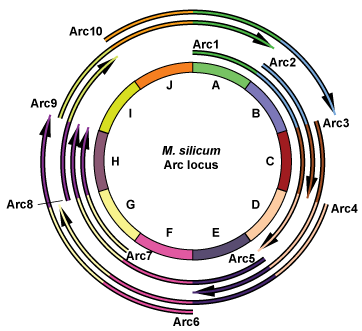
  
The sand mouse Arc locus consists of ten segments A-J. Starting at each segment, it is transcribed into ten overlapping mRNA transcripts, Arc1-Arc10, each of which is 2-4 segments long. Each segment is exactly 1000nt long, so the total Arc circle is 10kb. Each of the ten Arc mRNA isoforms starts at a corresponding segment, and is 2-4 segments (2000-4000nt) long.  

Moriarty did 100,000 single-ended, non-strand-specific 75nt reads from a cDNA fragment library of mean length 150bp, standard deviation 20bp, with an estimated base-calling accuracy of 99.9% per base (Q30 bases). He analyzed his data with kallisto. Based on his results, Moriarty says that the Arc1-Arc10 transcript abundances (in TPM) are like:  

| Transcript | TPM |
| ----------- | ----------- |
| Arc1 | 19000 |
| Arc2 | 55000 |
| Arc3 | 280000 |
| Arc4 | 78000 |
| Arc5 | 92000 |
| Arc6 | 17000 |
| Arc7 | 84000 |
| Arc8 | 88000 |
| Arc9 | 25000 |
| Arc10 | 260000 |  
  
Here I am going to reproduce Moriarty's analysis, and to use a positive control simulation to test the accuracy of kallisto's quantitation.

## Reproduce Moriarty's analysis
  
Moriarty has provided me with a gzip'ed FASTA file containing the transcript sequences of the 10 Arc transcripts, and a gzip'ed FASTQ file containing his 100,000 reads. So I am goint to use kallisto to analyze these data and reproduce his result.  

In [1]:
# Install kallisto with the Homebrew package manager
! brew install kallisto
# Check the program
! kallisto

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> New Formulae
apache-pulsar       jpdfbookmarks       pkgconf             viu
bat-extras          librist             red-tldr
==> Updated Formulae
Updated 165 formulae.

To reinstall 0.46.2, run:
  brew reinstall kallisto
kallisto 0.46.2

Usage: kallisto <CMD> [arguments] ..

Where <CMD> can be one of:

    index         Builds a kallisto index 
    quant         Runs the quantification algorithm 
    bus           Generate BUS files for single-cell data 
    pseudo        Runs the pseudoalignment step 
    merge         Merges several batch runs 
    h5dump        Converts HDF5-formatted results to plaintext
    inspect       Inspects and gives information about an index
    version       Prints version information
    cite          Prints citation information

Running kallisto <CMD> without arguments prints usage information for <CMD>



In [2]:
# Build a kallisto index of the transcriptome
! kallisto index -i transcripts.idx arc.fasta.gz


[build] loading fasta file arc.fasta.gz
[build] k-mer length: 31
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 19 contigs and contains 10000 k-mers 



We have built a new index file called "transcripts.idx", which used 31-mers, and its de Bruijn graph has 19 contigs and 10000 vertices.

In [3]:
# Map and quantitate reads against transcriptome
    # analyze in single-ended mode, with a fragment length distribution of mean = 150bp and sd = 20bp
! kallisto quant -i transcripts.idx -o output --single -l 150 -s 20 arc.fastq.gz  


[quant] fragment length distribution is truncated gaussian with mean = 150, sd = 20
[index] k-mer length: 31
[index] number of targets: 10
[index] number of k-mers: 10,000
[index] number of equivalence classes: 26
[quant] running in single-end mode
[quant] will process file 1: arc.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 100,000 reads, 99,980 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 62 rounds



Here is the output of kallisto:  

| Transcript | TPM |
| ----------- | ----------- |
| Arc1 | 19063.2 |
| Arc2 | 55123 |
| Arc3 | 282305 |
| Arc4 | 77552.6 |
| Arc5 | 92328.7 |
| Arc6 | 17073.6 |
| Arc7 | 83567.2 |
| Arc8 | 87953.1 |
| Arc9 | 25351.7 |
| Arc10 | 259682 |   

My analysis results are very close to Moriarty's, so I can admit that Moriarty's research is reproducible (when using the data provided by him).  
  
But is it possible that there is something wrong with the kallisto method? Next, I try to simulate some data to test the accuracy of kallisto.

## Simulate an Arc transcriptome
  
In order to provide a positive control for our analysis, I am going to simulate an Arc locus, an Arc transcriptome, and 100,000 reads from an RNA-seq experiment on the Arc transcriptome.  
   
First, I am going to simulate the Arc transcriptome:

In [4]:
# Set up the Arc locus parameters
S         = 10           # Number of segments in the Arc locus (A..J)
T         = 10           # Number of different transcripts (1..10)
len_S     = 1000         # length of each segment (nucleotides)
len_Arc   = len_S * S    # total length of the Arc locus (nucleotides)

In [5]:
# Generate an Arc locus DNA sequence
import numpy as np
Arc = {}
np.random.seed(99)       # set a seed for reproducibility 
for i in range(1,11):    # for each segment, choose its sequence of 1000 random 'ACGT's
    Arc[i] = np.random.choice(list('ACGT'), len_S)

# Generate the Arc1..Arc10 mRNA transcripts (cDNA)
Arc1 = ''.join(np.concatenate((Arc[1],Arc[2],Arc[3],Arc[4])))
Arc2 = ''.join(np.concatenate((Arc[2],Arc[3])))
Arc3 = ''.join(np.concatenate((Arc[3],Arc[4],Arc[5])))
Arc4 = ''.join(np.concatenate((Arc[4],Arc[5],Arc[6],Arc[7])))
Arc5 = ''.join(np.concatenate((Arc[5],Arc[6],Arc[7],Arc[8])))
Arc6 = ''.join(np.concatenate((Arc[6],Arc[7],Arc[8])))
Arc7 = ''.join(np.concatenate((Arc[7],Arc[8])))
Arc8 = ''.join(np.concatenate((Arc[8],Arc[9])))
Arc9 = ''.join(np.concatenate((Arc[9],Arc[10],Arc[1])))
Arc10 = ''.join(np.concatenate((Arc[10],Arc[1],Arc[2])))

# Put them into a transcripts set
transcripts = [Arc1,Arc2,Arc3,Arc4,Arc5,Arc6,Arc7,Arc8,Arc9,Arc10]

In [6]:
# Write the transcripts into a FASTA file
def writeFASTA(FASTA, n, transcripts):
    for i in range(n):     # for each transcript
        FASTA.write('>Arc%i the no.%i transcript of Arc locus' %(i+1,i+1)) # write the header line with its name and description 
        FASTA.write('\n')     # start a new line
        FASTA.write(transcripts[i])   # write the sequence
        FASTA.write('\n')     # start a new line
writeFASTA(FASTA = open('ArcTranscripts.fasta','w'),n=10,transcripts=transcripts)
# Check the file
! head ArcTranscripts.fasta

>Arc1 the no.1 transcript of Arc locus
CTCACAGACACTGTTCCACTGTATGAAAAACTTTGTTGCGAACGCCACTCTTGGGTCAAACTCATGTCTCCTCACATAACGCATATCTTGAGCAGTGTGAATGTCCCCCAACCCTGTTGTAACTGGTTCTGTCATTACTCCCTTAAAGGTAAATAGCGAAATCCATCGGTGTGGACAGGAGCTCGGTGTTTGCGGGGCTGGGTTTTTGAGTAACCGTTCCCGCCAGTAAGTGAGTAGCCTACTACTTCCAGTCGGCTCCGAATTATTATACCGAGAGCGCAAATTTCGGTGAGCGGCCGCAGCATGCCAGCCAAAGAGTCTCGTCGTCGTCAAAGGGCAGACTACTTCCAGCGTTCAAACGACGGGACGCATCGATTAGTGTGAAATCCATCGTGTCGCTATCTGTGGACATGTTTGCACGAACTTAATTTTCAGCACTATCAAGAAGAATTTTGGTAAATCCTTAGTTTATTTATCACTTGGGAGACAGAAGGACTGCGCATCACCACACAGCAGTCTTGCCTGACATCCGGTTAGACGGCAAGTGGTTGGCAACCGGATTCGATAATGATTACGGCATCGTTTCTATAGAGATCTCTGACTTGCTGGAGATCCCGTCATACCATATACACTTAACTGGTATTGTACTACATTTTTAAAAAGAGCCTGCTGCTTGAACGGTGCGCAACTTCTGTTCTGTGCTGGTCAAAGGGTGTAGAGTAACACTCGTACGGCGTGTCAACACCACGCCTCAACTCAAAACATAATGCAGACTTGAGTATGACCGCCACTAGCTCCTATGGCGTTATGTTTCCCCGGTGCGTTCATGATATCCCCCACGGTGCTCTGAATTCGTGTCCTTCTTACGGCGGGGATTCACTTGACTGCGCCTACTACGCGCATGCTACGGCCGCCAGTTAAGCGAGTCCCGCTGCTCTATTAGTAGGACCCAGGGAACGTG

## Simulate RNA-seq reads
After generating the FASTA file for Arc transcripts, next I will simulate the process of obtaining a cDNA fragment and then generate a read from one of its ends. 
  
I am going to use the results from my PhD thesis research for the nucleotide abundance of each transcript, which is:  

| Transcript | Abundance ($\nu_i$) |
| ----------- | ----------- |
| Arc1 | 0.008 |
| Arc2 | 0.039 |
| Arc3 | 0.291 |
| Arc4 | 0.112 |
| Arc5 | 0.127 |
| Arc6 | 0.008 |
| Arc7 | 0.059 |
| Arc8 | 0.060 |
| Arc9 | 0.022 |
| Arc10 | 0.273 | 

In [7]:
# Set up the parameters
mean_frag = 150          # fragment size: mean (of a truncated Gaussian)
sd_frag   = 20           # fragment size: stdev
alpha     = 0.999        # base calling accuracy (Q30 bases, typical of current Illumina)
len_R     = 75           # read length
N         = 100000       # total number of observed reads we generate
ν         = [0.008,0.039,0.291,0.112,0.127,0.008,0.059,0.060,0.022,0.273] # nucleotide abundance of each transcript from my data

# Define the functions
def complement(seq):  # define a function to give the complement sequence
    return seq.translate(str.maketrans('ACGT', 'TGCA'))
def revcomp(seq):     # define a function to give the reverse complement sequence
    return complement(seq)[::-1]
def BCE(seq,alpha):           # define a function to generate base calling errors
    p_other = (1-alpha)/3     # calculate the error rate according to alpha
    p = [alpha,p_other,p_other,p_other]
    seq_list = list(seq)      # create a list to store the mutated seq
    for i in range(len(seq)): # iterate through each base
        if seq[i] == 'A':
            seq_list[i] = np.random.choice(list('ACGT'),p = p)
        elif seq[i] == 'T':
            seq_list[i] = np.random.choice(list('TCGA'),p = p)
        elif seq[i] == 'C':
            seq_list[i] = np.random.choice(list('CTGA'),p = p)
        else: seq_list[i] = np.random.choice(list('GCTA'),p = p)
    return ''.join(seq_list)

# Define the reads simulator
def reads_simulation(transcripts,ν,FASTQ = open('Reads.fastq','w'),mean_frag = 150,sd_frag = 20,alpha = 0.999,len_R = 75,N = 100000):
    
    # Repeat below for all reads
    for j in range(N):

        # Sample a transcript i+1 according to its nucleotide abundance νi+1
        norm_ν = ν/np.sum(ν,keepdims=True)  # normalize ν so the sum could be 1
        i = np.random.choice(range(10), p=norm_ν) # pick a random transcript i+1

        # Pick a random fragment length of a truncated Gaussian distribution
        while True:
            len_frag = int(np.random.normal(mean_frag, sd_frag))
            if len_frag >= len_R: break  # only return the fragment length that greater than the read length
        if len_frag > len(transcripts[i]): len_frag = transcripts[i-1]  # if it's greater than the transcript, set it to equal

        # Pick a random fragment of that length from the transcript
        frag_start = np.random.choice(len(transcripts[i])-len_frag+1) # pick a random start point
        frag = transcripts[i][frag_start:frag_start+len_frag] # get the fragment sequence by index

        # Pick a 75nt read from the fragment
        read_start = np.random.choice(len_frag-len_R+1) # pick a random start point
        strand = np.random.choice(2)                    # choose a random orientation
        if strand == 0 :                                # for the top strand
            read = frag[read_start:read_start+len_R]    # get the read sequence by index
        else: read = revcomp(frag)[read_start:read_start+len_R]  # for the bottom strand

        # Add simulated base calling errors
        read = BCE(read,alpha)

        # Output the read to a FASTQ file
        FASTQ.write('@Read%i:Arc%i:%i:%i' %(j+1,i+1,frag_start,len_frag)) # write the header line with its id and other info
        FASTQ.write('\n')     # start a new line
        FASTQ.write(read)     # write the sequence
        FASTQ.write('\n+\n')  # write a new line with only a + on it
        FASTQ.write('I'*75)   # add the quality values as 'I'
        FASTQ.write('\n')     # start a new line

In [8]:
# Simulate the reads 
FASTQ = open('ArcReads.fastq','w') # set up the output file
np.random.seed(99)                 # set a seed for reproducibility 
reads_simulation(transcripts, ν = ν, FASTQ = FASTQ) # run the reads simulator
! head ArcReads.fastq              # check the file

@Read1:Arc8:1746:176
AATGAACGGCCTGTGGCAAACGTTGTTCCAAACATTACGCCAGCTGGAAAGGTTAGTGAATAAGGTGAATGTGTC
+
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
@Read2:Arc5:2523:149
TTTGGGTCACGTGGGCAACTCTGTGAGCGTCGCCAGGGTGGGATTATGTTGGACGTCCTACACCTCAGAAACCCT
+
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
@Read3:Arc4:1583:173
TTTGCATTTATGCCTAGAGATGGACTCGCGTAAGCCACGGTCGGGCCCCTCATACACTGGCTTCGTGTGCTCGAA


## Analyze the simulated data
After simulation of an Arc locus, an Arc transcriptome, and 100,000 reads from an RNA-seq experiment on the Arc transcriptome, next we are going to analyze those data using kallisto.  

In [9]:
# Analyze the simulated data

# Build a kallisto index of the transcriptome
! kallisto index -i simulated_transcripts.idx ArcTranscripts.fasta

# Map and quantitate reads against transcriptome
    # analyze in single-ended mode, with a fragment length distribution of mean = 150bp and sd = 20bp
! kallisto quant -i simulated_transcripts.idx -o simulated_output --single -l 150 -s 20 ArcReads.fastq


[build] loading fasta file ArcTranscripts.fasta
[build] k-mer length: 31
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 19 contigs and contains 10000 k-mers 


[quant] fragment length distribution is truncated gaussian with mean = 150, sd = 20
[index] k-mer length: 31
[index] number of targets: 10
[index] number of k-mers: 10,000
[index] number of equivalence classes: 26
[quant] running in single-end mode
[quant] will process file 1: ArcReads.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 99,995 reads, 99,982 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 142 rounds



Here is the output of kallisto:  

| Transcript | TPM_kallisto | TPM_input |
| ----------- | ----------- | ----------- |
| Arc1 | 29128.8 | 6000 |
| Arc2 | 69935.5 | 58000 |
| Arc3 | 266768 | 290000 |
| Arc4 | 74801.8 | 83000 |
| Arc5 | 109057 | 94000 |
| Arc6 | 5354.45 | 7800 |
| Arc7 | 83423.2 | 87000 |
| Arc8 | 82236.4 | 88000 |
| Arc9 | 43989.8 | 22000 |
| Arc10 | 235305 | 270000 | 

By comparing with the input data, we can tell from the result that kallisto get the correct answer (approximately) for most of the transcripts: e.g., Arc2 (69935.5 vs 58000), Arc3 (266768 vs 290000), Arc4 (74801.8 vs 83000).  
  
However, there are some apparent inconformity as well: Arc1 (29128.8 vs 6000), Arc9 (43989.8 vs 22000) and Arc10 (235305 vs 270000).

## Debug kallisto

To find the reason behind kallisto's incorrectness, we need to look at its algorithm principle.  
  
Kallisto is based on pseudoalignment of reads and fragments, which focuses only on identifying the transcripts from which the reads could have originated and does not try to pinpoint exactly how the sequences of the reads and transcripts align. [(Bray, N., Pimentel, H., Melsted, P. et al. Near-optimal probabilistic RNA-seq quantification. Nat Biotechnol 34, 525–527 (2016).)](https://www.nature.com/articles/nbt.3519) 

Reads are pseudoaligned by looking up the k-compatibility class for each k-mer in the read in the kallisto index and then intersecting the identified k-compatibility classes. To speed up the processing, kallisto uses the structural information stored in the index: because all k-mers in a contig of the T-DBG have the same k-compatibility class, it would be redundant to include more than one k-mer from a contig in the intersection of k-compatibility classes. 
  
That is to say, **since the Arc locus is excised from the genome and circularized, which makes its mRNA transcripts overlapping, kallisto may mistake some k-mers for belonging to other k-compatibility classes (i.e. transcripts), leading to miscalculations of nucleotide abundances.**

We could then test this hypothesis on a non-overlapping transcriptome:  

In [10]:
# Generate the reads from non-overlapping transcripts
debug_transcripts = {}
for i in range(10):  # for convenience, we will just use ten segments of Arc as its ten transcripts:
    debug_transcripts[i] = ''.join(Arc[i+1])
writeFASTA(FASTA = open('DebugTranscripts.fasta','w'), n = 10, transcripts = debug_transcripts)

# Simulate the reads 
FASTQ = open('DebugReads.fastq','w') # set up the output file
np.random.seed(99)                   # set a seed for reproducibility 
ν = np.ones(10)                      # for convenience, set all nucleotide abundances to be equal
reads_simulation(debug_transcripts, ν, FASTQ) # run the reads simulator

# Analyze the debug data
  # build a kallisto index of the transcriptome
! kallisto index -i debug_transcripts.idx DebugTranscripts.fasta

  # map and quantitate reads against transcriptome
    # analyze in single-ended mode, with a fragment length distribution of mean = 150bp and sd = 20bp
! kallisto quant -i debug_transcripts.idx -o debug_output --single -l 150 -s 20 DebugReads.fastq


[build] loading fasta file DebugTranscripts.fasta
[build] k-mer length: 31
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 10 contigs and contains 9700 k-mers 


[quant] fragment length distribution is truncated gaussian with mean = 150, sd = 20
[index] k-mer length: 31
[index] number of targets: 10
[index] number of k-mers: 9,700
[index] number of equivalence classes: 10
[quant] running in single-end mode
[quant] will process file 1: DebugReads.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 99,965 reads, 95,302 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 52 rounds



When using non-overlapping transcripts with the same length and nucleotide abundance($\nu_i$), the output of kallisto is :

| Transcript | TPM |
| ----------- | ----------- |
| 1 | 99483.7 |
| 2 | 99294.9 |
| 3 | 101026 |
| 4 | 98927.6 |
| 5 | 99106 |
| 6 | 99914 |
| 7 | 99252.9 |
| 8 | 101121 |
| 9 | 101110 |
| 10 | 100764 | 

Since nucleotide abundance $\nu_i$ divided by effictive transcript length is proportional to TPM, and we generated the debug data with the same transcript length, we can tell from the result that kallisto works pretty good on our newly simulated data, which verifies my previous hypothesis.  
   
Therefore, we could conclude that: 

**Although kallisto has a great reproducibility (for repeating Moriarty's analysis), it may be inaccurate when analysing the circular sand mouse Arc locus which transcribes into overlapping mRNA transcripts, and we may need to further look for other algorithms for this research.**